In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from copy import deepcopy
from scipy.interpolate import interp1d

In [33]:
# S start date, T end date, K strike price, tau period between two payments, ZC zero-coupon curve, assume today is start date
def VOSwap(S, T, K, tau, ZC):
    
    temp = 0
        
    for idx in range(int((T-S)/tau)):
        temp += tau * ZC(S + (idx + 1) * tau)
            
    P_S = ZC(S)
    P_T = ZC(T)

    return (P_S - P_T) - K * temp   # Value of Swap

# Zero-coupon curve configuration
def ZC_config(t,ti,ri):

    if t>=ti[-1]:
        r = ri[-1]
    elif t<=ti[0]:
        r= ri[0]
    else:
        r = interp1d(ti, ri, kind='cubic')(t)
    
    return np.exp(-r*t)       # return the value of ZC

# Forward curve configuration. Return calibrated spine points by Newton-Raphson
def FC_config(ti, r0, th):
    ri = deepcopy(r0)
    err = 1
    while err > th:
        values = Eval(ti,ri)
        J = Jacobian(ti,ri)
        J_inv = np.linalg.inv(J)
        err = - np.dot(J_inv, values)
        ri += err 
        err = np.linalg.norm(err)
        print('Error Term:', err)
    return ri

# Construct the forward curve from spline points by cubic interpolation
def FC(t, ti, ri):
    if t>=ti[-1]:
        r = ri[-1]
    elif t<=ti[0]:
        r= ri[0]
    else:
        r = interp1d(ti, ri, kind='cubic')(t)
    
    return r

# Calculate the Jacobian of the values of instruments w.r.t. forward rates
def Jacobian(ti, ri):
    eps = 1e-05
    J = np.zeros([len(ti), len(ti)])
    val = Eval(ti,ri)
    for j in range(len(ri)):
        ri[j] += eps  
        val_new = Eval(ti,ri)
        ri[j] -= eps
        J[:, j] = (val_new - val) / eps
    return J

# Evaluate the instruments
def Eval(ti,ri):
    ZC = lambda t: ZC_config(t,ti,ri)
    val = np.zeros(len(inst))
    for i in range(len(inst)):
        val[i] = inst[i](ZC)
    return val

# Iteration thredshold
th = 1e-8
# Initial values for forward rates
r0 = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])   

# 1-month Term SOFR swap rates on a day in March 2024
K   = np.array([0.04901, 0.04436, 0.04169, 0.03937, 0.03859, 0.03824, 0.03834, 0.03633])
# Corresponding maturities
mat = np.array([1, 2, 3, 5, 7, 10, 15, 30])
# Periods between two payments
tau = 1 / 12

# List of instruments
inst = [lambda ZC, i=i: VOSwap(0, mat[i], K[i], tau, ZC) for i in range(len(K))]

# Calibrate forward rates
ri = FC_config(mat, r0, th)

# Zero-Coupon curve
ZC = lambda t: ZC_config(t, mat, ri)
# Forward curve
FC_final = lambda t: FC(t, mat, ri)
    

Error Term: 0.07916838445530787
Error Term: 0.009792594219538963
Error Term: 0.0007957698007494405
Error Term: 8.893494849198157e-06
Error Term: 1.7488206042775758e-10


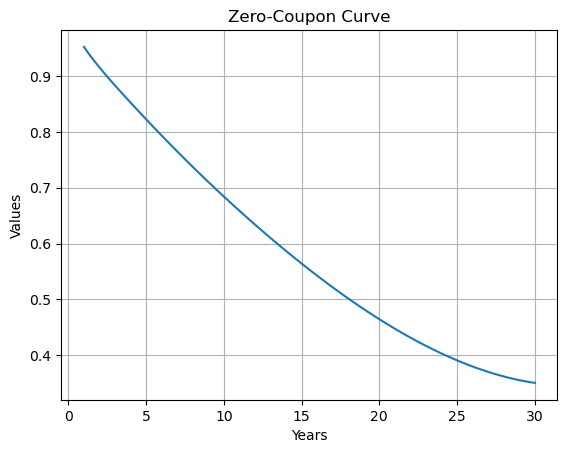

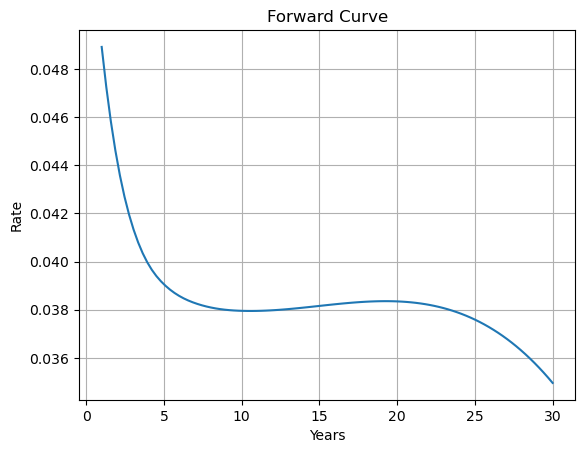

In [32]:
# Plot Zero-Coupon curve and Forward curve
t_val = np.linspace(1, 30, 100)  

zc_val = [ZC(t) for t in t_val]
fc_val = [FC_final(t) for t in t_val]

plt.plot(t_val, zc_val)
plt.title("Zero-Coupon Curve")
plt.xlabel("Years")
plt.ylabel("Values")
plt.grid(True)
plt.show()

plt.plot(t_val, fc_val)
plt.title("Forward Curve")
plt.xlabel("Years")
plt.ylabel("Rate")
plt.grid(True)
plt.show()